<a href="https://colab.research.google.com/github/dnevo/Practicum/blob/master/S05_Integrated_Project_1_%E2%80%93_hypothesis_on_user_rating_of_video_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border:solid green 4px; padding: 20px">Hello! My critical comments are highlighted with <span style='color: red;'>red</span>,  less urgent remarks are in <span style='color: #ebd731;'>yellow</span>, recommendations and extra information - in <span style='color: green;'>green</span>.</div>

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:11,.2f}'.format

### Step 1. Open the data file and study the general information.

In [6]:
games = pd.read_csv('https://raw.githubusercontent.com/dnevo/Practicum/master/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,nan,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,nan,NaN,NaN


In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Referring to above `.info()`, we can already notice few thing:
1. Year_of_release: contains 269 missing values. In addition, it should be converted to integer
2. Critic_Score: more than 50% missing values
3. User_Score: 40% missing values. In addition the type is 'Object', indicating some non-numeric values.
4. Rating: 40% missing values.

In [ ]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


Referring to above `.describe()` we can notice:
1. Year of release: although first release is in 1980, most of the titles were released after year 2000.
2. Sales (in all 4 regions) is very positively skewed - implying that sales hits are very rare.
3. Critic_Score: is negatively skewed - this may be attributed to psychological reasons: critics, as other human beings, do not feel comfortable to give a very negative score.
4. User_score: does not appear in this table - we will check why later.

<div style="border:solid green 4px; padding: 20px">Very good.</div>

### Step 2. Prepare the data

Replace the column names (make them lowercase).

In [ ]:
games.columns = map(str.lower, games.columns)
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'], dtype='object')

Convert `user_score` to float - before doing that, note that the column include a large amount (40%) of 'tbd' values - in order to avoid losing information, we will convert them to NaNs.

In [ ]:
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = games['user_score'].astype(float)

`user_score` distribution - is negatively skewed, similar to `critic_score`, and probably for same psychological reasons:

In [ ]:
games['user_score'].describe()

count      7,590.00
mean           7.13
std            1.50
min            0.00
25%            6.40
50%            7.50
75%            8.20
max            9.70
Name: user_score, dtype: float64

Missing values in `name` and `genre` columns:
- There are exactly 2 rows in which both `name` and `genre` are missing
- Since it is just 2 rows, there will be no impact in removing them.

In [ ]:
games = games[games['name'].notna()]

Missing values in `year_of_release`: in case there is another title with same name, we will be able to use the year of that title (although it may not be true for 100% of the cases, it is still a reasonable assumption).

In [ ]:
# title_year will contain name (no duplicates) and year_of_release
title_year = games.loc[games['year_of_release'].notna(),['name','year_of_release']]
title_year.drop_duplicates(subset='name',inplace=True)

def assign_year(row):
  if pd.isna(row['year_of_release']):
    title_year_val = title_year[title_year['name'] == row['name']]['year_of_release']
    if title_year_val.empty:
      return np.nan
    else:
      return float(title_year_val)
  else:
    return row['year_of_release']
games['year_of_release'] = games.apply(assign_year, axis=1)

# To look nice, we will convert year from float to integer.
# Note: Int64 is the only integer datatype allowing array as integer while having NaN values
games['year_of_release'] = games['year_of_release'].astype('Int64')

Missing values in `rating`: in case there is another title with same name, we will be able to use the rating of that title (although it may not be true for 100% of the cases, it is still a reasonable assumption).

In [ ]:
# title_rating will contain name (no duplicates) and rating
title_rating = games.loc[games['rating'].notna(),['name','rating']]
title_rating.drop_duplicates(subset='name',inplace=True)

def assign_rating(row):
  if pd.isna(row['rating']):
    title_rating_val = title_rating[title_rating['name'] == row['name']]['rating']
    if title_rating_val.empty:
      return np.nan
    else:
      return title_rating_val.values[0]
  else:
    return row['rating']
games['rating'] = games.apply(assign_rating, axis=1)

Display `rating` sorted by frequency:

In [ ]:
games.groupby(by='rating')['rating'].count().sort_values(ascending=False)

rating
E       4151
T       3094
M       1653
E10+    1470
EC        10
K-A        4
RP         3
AO         1
Name: rating, dtype: int64

<div style="border:solid green 4px; padding: 20px">Great replacements.</div>

We will drop games with rare ratings (count <= 10):

In [ ]:
rare_ratings = ['EC', 'RP','K-A','AO']
games = games.query('rating not in @rare_ratings')

As we can see, Action and Sports games are the most popular in term of number of games:

In [ ]:
games.groupby(by='genre')['genre'].count().sort_values(ascending=False)

genre
Action          3367
Sports          2348
Misc            1742
Role-Playing    1498
Shooter         1323
Adventure       1301
Racing          1248
Platform         888
Simulation       873
Fighting         849
Strategy         678
Puzzle           580
Name: genre, dtype: int64

Calculate the total sales in every region and put these values in a separate column (total all regions).

In [ ]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

As we can see the data base contains very few titles before 1990 (except '2600' and 'NES' which is anyway obsolete for the last 25 years):

In [ ]:
games.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,9.00,46.00,36.00,11.00,1.00,1.00,2.00,6.00,2.00,2.00,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3DO,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3DS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,116.00,94.00,91.00,80.00,86.00,46.00
DC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.00,14.00,20.00,8.00,1.00,nan,nan,nan,nan,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan
DS,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,118.00,201.00,377.00,494.00,403.00,322.00,154.00,24.00,8.00,nan,nan,nan
GB,nan,nan,nan,nan,nan,nan,nan,nan,1.00,10.00,3.00,9.00,7.00,nan,3.00,4.00,6.00,8.00,8.00,11.00,17.00,10.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GBA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,107.00,198.00,150.00,175.00,136.00,40.00,6.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
GC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,155.00,148.00,83.00,97.00,41.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
GEN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,1.00,6.00,7.00,12.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Therefore, we will remove these titles:

In [ ]:
games = games[games['year_of_release'] >= 1990]
games.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')

year_of_release,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,
2600,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3DO,nan,nan,nan,nan,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3DS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,116.00,94.00,91.00,80.00,86.00,46.00
DC,nan,nan,nan,nan,nan,nan,nan,nan,7.00,14.00,20.00,8.00,1.00,nan,nan,nan,nan,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan
DS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,118.00,201.00,377.00,494.00,403.00,322.00,154.00,24.00,8.00,nan,nan,nan
GB,3.00,9.00,7.00,nan,3.00,4.00,6.00,8.00,8.00,11.00,17.00,10.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GBA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,107.00,198.00,150.00,175.00,136.00,40.00,6.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
GC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,155.00,148.00,83.00,97.00,41.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
GEN,1.00,1.00,6.00,7.00,12.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Platforms: As we can see there are platforms with very few titles (ex. '2600', GC', 'PCFX').

In [ ]:
platforms = games.groupby(by='platform')['platform'].count().sort_values(ascending=False)
platforms

platform
PS2     2139
DS      2124
PS3     1320
Wii     1299
X360    1250
PSP     1203
PS      1188
PC       962
XB       816
GBA      813
GC       551
3DS      515
PSV      429
PS4      392
N64      318
XOne     247
SNES     239
SAT      173
WiiU     147
GB        86
DC        52
GEN       27
NES       23
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
2600       1
Name: platform, dtype: int64

As we can see, all platforms with less than 100 titles were made obsolete by 2008:

In [ ]:
platforms_lt_100 = list(games.groupby(by='platform')['platform'].count()[platforms<100].index)
games.query('platform in @platforms_lt_100').pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')

year_of_release,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2007,2008
platform,,,,,,,,,,,,,,,
2600,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3DO,nan,nan,nan,nan,1.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
DC,nan,nan,nan,nan,nan,nan,nan,nan,7.00,14.00,20.00,8.00,1.00,1.00,1.00
GB,3.00,9.00,7.00,nan,3.00,4.00,6.00,8.00,8.00,11.00,17.00,10.00,nan,nan,nan
GEN,1.00,1.00,6.00,7.00,12.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
GG,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NES,8.00,7.00,3.00,4.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
NG,nan,nan,nan,2.00,4.00,4.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan
PCFX,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan


Therefore, we can safely remove these titles:

In [ ]:
games = games.query('platform not in @platforms_lt_100')
games.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')

year_of_release,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,,,,,,,
3DS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,116.00,94.00,91.00,80.00,86.00,46.00
DS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,118.00,201.00,377.00,494.00,403.00,322.00,154.00,24.00,8.00,nan,nan,nan
GBA,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,107.00,198.00,150.00,175.00,136.00,40.00,6.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
GC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,23.00,155.00,148.00,83.00,97.00,41.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
N64,nan,nan,nan,nan,nan,nan,18.00,49.00,77.00,103.00,60.00,9.00,1.00,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PC,nan,nan,5.00,nan,6.00,2.00,4.00,4.00,8.00,7.00,7.00,15.00,19.00,34.00,30.00,37.00,52.00,62.00,77.00,108.00,90.00,140.00,63.00,41.00,47.00,50.00,54.00
PS,nan,nan,nan,nan,17.00,99.00,163.00,188.00,247.00,200.00,160.00,91.00,20.00,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PS2,nan,nan,nan,nan,nan,nan,nan,nan,1.00,nan,82.00,185.00,285.00,258.00,259.00,259.00,263.00,215.00,191.00,96.00,38.00,7.00,nan,nan,nan,nan,nan
PS3,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00,27.00,90.00,139.00,162.00,187.00,219.00,149.00,126.00,108.00,73.00,38.00


As can be seen in above table, there are 2 mistakes in the data regarding platforms appearing in data years before they were created:
- PS3: record in data: 1991. created: 2006
- 3DS: record in data: 2000. created: 2010

We will remove these records to avoid wrong platform distributions per year

In [ ]:
games.drop(games[(games['platform'] == 'PS3') & (games['year_of_release'] == 1991)].index, inplace=True)
games.drop(games[(games['platform'] == '3DS') & (games['year_of_release'] == 2000)].index, inplace=True)

<div style="border:solid green 4px; padding: 20px">Honestly, no questions!</div>

### Step 3. Analyze the data

Select the 5 platforms with the highest total sales (should have 0 sale in 2016)

-	Look at how many games were released in different years. Is the data for every period (year) significant?
  - Look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for how many games were released each year for the five platforms with the highest total sales. Find the top 5 platforms that have the most games released per a single year but in subsequent years have zero game releases (Year_of_Release). How many years does it take from the year of the first Year_of_Release to the year in which there are no releases for each of the top 5 platforms?
  -	Determine what period you should take data for. To do so, look at your answers to the previous questions. The key criterion is that the data should allow you to build a prognosis for 2017.
  -	Work only with the data that you've decided is relevant. Disregard the data for previous years.

In [ ]:
top5_platforms = list(games.groupby(by='platform')['total_sales'].sum().sort_values(ascending=False).head().index)
top5_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS']

Not surprisingly, these 5 platforms share also the most titles:

In [ ]:
list(games.groupby(by='platform')['platform'].count().sort_values(ascending=False).head().index)

['PS2', 'DS', 'PS3', 'Wii', 'X360']

For each of the 5: Build a distribution of # of games released per year

In [ ]:
top5_platforms_games = games.query('platform in @top5_platforms')
top5_distribution = top5_platforms_games.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')
top5_distribution

year_of_release,1998,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,
DS,nan,nan,nan,nan,nan,23.00,118.00,201.00,377.00,494.00,403.00,322.00,154.00,24.00,8.00,nan,nan,nan
PS2,1.00,82.00,185.00,285.00,258.00,259.00,259.00,263.00,215.00,191.00,96.00,38.00,7.00,nan,nan,nan,nan,nan
PS3,nan,nan,nan,nan,nan,nan,1.00,27.00,90.00,139.00,162.00,187.00,219.00,149.00,126.00,108.00,73.00,38.00
Wii,nan,nan,nan,nan,nan,nan,nan,48.00,187.00,286.00,325.00,252.00,146.00,32.00,12.00,6.00,4.00,1.00
X360,nan,nan,nan,nan,nan,nan,21.00,94.00,123.00,147.00,174.00,185.00,212.00,108.00,75.00,63.00,35.00,13.00


For each of the 5 platforms, Calculate average number of years lifespan. The mean is 11.8 years

In [ ]:
print(top5_distribution.notna().sum(axis=1))
print('mean=',top5_distribution.notna().sum(axis=1).mean())

platform
DS      10
PS2     13
PS3     12
Wii     11
X360    12
dtype: int64
mean= 11.6


We will remove PC (Desktop computer), since actually it does not behave like all other platforms

In [ ]:
games_no_pc = games.drop(games[(games['platform'] == 'PC')].index)

Distribution of sales per active platforms (platforms with active sales in 2016)

In [ ]:
platforms_sales_tmp = games_no_pc.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='sum')
platforms_sales = platforms_sales_tmp[platforms_sales_tmp[2016]>0].dropna(axis=1, how='all')
platforms_sales

year_of_release,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,
3DS,nan,nan,nan,nan,nan,0.30,63.20,51.76,56.57,43.76,27.78,15.14
PS3,0.19,20.96,73.19,118.79,130.93,142.96,157.98,108.28,113.25,47.76,16.82,3.60
PS4,nan,nan,nan,nan,nan,nan,nan,nan,25.99,100.00,118.90,69.25
PSV,nan,nan,nan,nan,nan,nan,4.63,16.19,10.59,11.90,6.25,4.25
Wii,nan,140.19,153.41,177.68,206.97,128.01,59.79,22.94,8.59,3.75,1.14,0.18
WiiU,nan,nan,nan,nan,nan,nan,nan,17.56,21.65,22.03,16.35,4.60
X360,9.22,51.79,95.41,136.07,120.82,170.55,145.23,100.72,88.58,34.74,11.96,1.52
XOne,nan,nan,nan,nan,nan,nan,nan,nan,18.96,54.07,60.14,26.15


Distribution of titles per active platforms (platforms with new titles in 2016)

In [ ]:
platforms_titles_tmp = games_no_pc.pivot_table(index='platform', columns='year_of_release', values='total_sales',aggfunc='count')
platforms_titles = platforms_titles_tmp[platforms_titles_tmp[2016]>0].dropna(axis=1, how='all')
platforms_titles

year_of_release,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,
3DS,nan,nan,nan,nan,nan,1.00,116.00,94.00,91.00,80.00,86.00,46.00
PS3,1.00,27.00,90.00,139.00,162.00,187.00,219.00,149.00,126.00,108.00,73.00,38.00
PS4,nan,nan,nan,nan,nan,nan,nan,nan,16.00,75.00,137.00,164.00
PSV,nan,nan,nan,nan,nan,nan,18.00,53.00,63.00,100.00,110.00,85.00
Wii,nan,48.00,187.00,286.00,325.00,252.00,146.00,32.00,12.00,6.00,4.00,1.00
WiiU,nan,nan,nan,nan,nan,nan,nan,32.00,42.00,31.00,28.00,14.00
X360,21.00,94.00,123.00,147.00,174.00,185.00,212.00,108.00,75.00,63.00,35.00,13.00
XOne,nan,nan,nan,nan,nan,nan,nan,nan,19.00,61.00,80.00,87.00


### Which platforms are leading in sales? Which ones are growing or shrinking? 
Referring to the 2 above tables:
1. Sales: PS4 is leading sales (69.25), followed by XOne (26.15) AND 3DS (15.14)
2. Growing: referring to the number of titles / year - PS4 is growing (164 in 2016 vs. 137 in 2015), followed by XOne (87 in 2016 vs. 80 in 2015)
3. Shrinking: all the rest of the platforms. Wii is expected to be eliminated, as just 1 title released in 2016

<div style="border:solid green 4px; padding: 20px">Your conclusions are correct. The approach you use - outputing all the intermediate calculations and not saving amount of cells - is very good, doesn't leave any questions to your analysis. Few students do that, keep it up.</div>

### Build a box plot for the global sales of each game, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.
As can be noted in the box plot - there is a significant difference between the 'long lifespan' platforms (Wii, X360 and PS3: 12 years) and the other platforms:
- The long-life spans are characterized by higher sales than the rest of the platform, and accordingly also wider quantiles.
- Note that we should exclude PS4 from the others, as it is in the beginning of it growth path (already reached 164 in 2016).

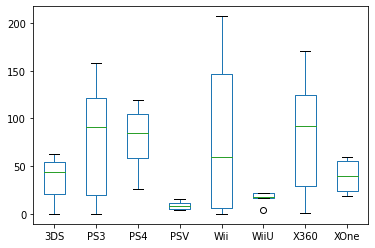

In [ ]:
platforms_sales.T.plot.box();

-	Take a look at how user and professional reviews affect sales for a particular popular platform. Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

<div style="border:solid green 4px; padding: 20px">So what are the conclusions on that? Looks like PS4 was the better choice, if investing money. Median sales is a bit less, but way more predictable than PS3 or X360. Seems like at the moment it was launched industry had learned to detect projects with low future sales well on early production stages. IQR of Wii shows how specific and high risk it was.</div>

### Correlation between `critic_score` and `total_sales`
As can be noticed in the plot bellow, the top selling games are characterized in high critics scores (top quartile: >79).

On the other hand, high score, does not guaranty high sales

0.2458581472996196


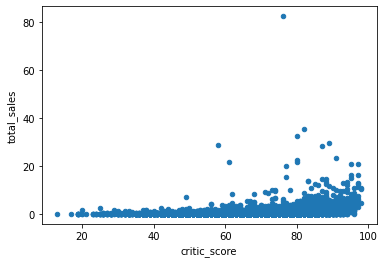

In [ ]:
print(games['critic_score'].corr(games['total_sales']))
games.plot.scatter(x='critic_score',y='total_sales');

### Correlation between `user_score` and `total_sales`
As can be noticed in the plot bellow, the top selling games are characterized in high users scores (8.2 or above).

On the other hand, high score, does not guaranty high sales

0.08842123782646255


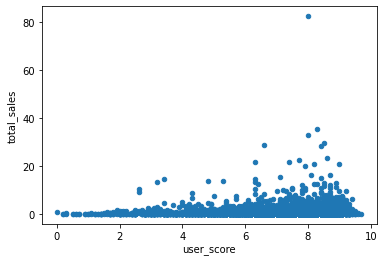

In [ ]:
print(games['user_score'].corr(games['total_sales']))
games.plot.scatter(x='user_score',y='total_sales');

###	Keeping your conclusions in mind, compare the sales of the same games on other platforms.
As is below table which concern sales in 2016:
1. PS4 is by far leading the sales, followed by XOne and PC
2. 3DS is special platform - it has its own games (see as example Pokemon Sun).

In [ ]:
games[games['year_of_release'] == 2016].pivot_table(
    index='name', columns='platform', values='total_sales',aggfunc='sum',margins=True
    ).sort_values(by='All',ascending=False).head(10)

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne,All
name,,,,,,,,,,
All,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15,129.94
FIFA 17,nan,0.12,0.73,7.60,nan,nan,nan,0.38,2.65,11.48
Pokemon Sun/Moon,7.14,nan,nan,nan,nan,nan,nan,nan,nan,7.14
Call of Duty: Infinite Warfare,nan,0.13,nan,4.47,nan,nan,nan,nan,2.42,7.02
Battlefield 1,nan,0.38,nan,4.07,nan,nan,nan,nan,2.25,6.70
Tom Clancy's The Division,nan,0.41,nan,3.80,nan,nan,nan,nan,2.17,6.38
Uncharted 4: A Thief's End,nan,nan,nan,5.39,nan,nan,nan,nan,nan,5.39
Overwatch,nan,0.53,nan,2.14,nan,nan,nan,nan,1.06,3.73
Far Cry: Primal,nan,0.16,nan,2.26,nan,nan,nan,nan,0.88,3.30


###	Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

Genre: distribution of games per genre in Y2016. As can be noticed, although Action is leading in term of number of titles (almost 50%!), it is not even leading in term of total sales (led by shoother which is also the most profitable), and has middle performance in term of profitability ('mean').

In [ ]:
g16 = games[games['year_of_release'] == 2016].groupby(by='genre').agg({'total_sales':['count', 'sum', 'mean']})
g16.columns = ['# of games', 'tot sales', 'mean']
g16.sort_values(by='mean', ascending=False)

,# of games,tot sales,mean
genre,,,
Shooter,47,38.22,0.81
Sports,48,23.49,0.49
Role-Playing,54,18.18,0.34
Fighting,16,4.47,0.28
Platform,15,3.23,0.22
Action,178,30.11,0.17
Racing,24,2.79,0.12
Simulation,18,1.89,0.11
Strategy,13,1.13,0.09


<div style="border:solid #ebd731; 4px; padding: 20px">I would really like to see some barcharts for comparison here.</div>

Genre: distribution of games per genre in all years. As can be noticed, although Action is leading in term of number of titles and total sales , it has middle performance in term of profitability ('mean').

In [ ]:
g = games.groupby(by='genre').agg({'total_sales':['count', 'sum', 'mean']})
g.columns = ['# of games', 'tot sales', 'mean']
g.sort_values(by='mean', ascending=False)

,# of games,tot sales,mean
genre,,,
Platform,812,643.12,0.79
Shooter,1275,987.24,0.77
Racing,1217,706.18,0.58
Role-Playing,1439,822.49,0.57
Sports,2285,"1,281.13",0.56
Fighting,809,427.14,0.53
Action,3259,"1,666.21",0.51
Simulation,850,383.86,0.45
Misc,1709,770.37,0.45


Distribution of sales per genre across the years:

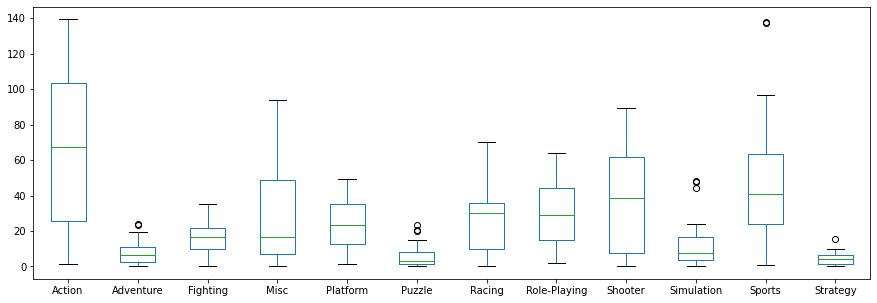

In [ ]:
genres_sales = games_no_pc.pivot_table(index='genre', columns='year_of_release', values='total_sales',aggfunc='sum')
genres_sales.T.plot.box(figsize=(15, 5));

<div style="border:solid green 4px; padding: 20px">Just noticed, aren't shooters and action - basically the same thing?</div>

### Step 4. Create a user profile for each region

### Top 6 platforms - 2016 sales per region
- North America: PS4 almost 50% of the market followed by XOne (31%)
- Japan: 3DS: 41% - in fact this platform is popular mostly in Japan. Following is PS4 with 30%
- Europe: PS4 is dominating with 62%, followed by XOne 19%

In [ ]:
sales_2016_regions = games[games['year_of_release'] == 2016].pivot_table(index='platform', values
    =['na_sales', 'eu_sales', 'jp_sales', 'total_sales'],aggfunc='sum').sort_values(
        by='total_sales', ascending=False)
sales_2016_regions['eu_sales(%)'] = sales_2016_regions['eu_sales'] / sales_2016_regions['eu_sales'].sum() * 100
sales_2016_regions['jp_sales(%)'] = sales_2016_regions['jp_sales'] / sales_2016_regions['jp_sales'].sum() * 100
sales_2016_regions['na_sales(%)'] = sales_2016_regions['na_sales'] / sales_2016_regions['na_sales'].sum() * 100
sales_2016_regions.head(6)

,eu_sales,jp_sales,na_sales,total_sales,eu_sales(%),jp_sales(%),na_sales(%)
platform,,,,,,,
PS4,31.78,5.74,21.49,69.25,62.05,29.73,47.83
XOne,9.63,0.01,14.27,26.15,18.80,0.05,31.76
3DS,2.33,8.03,4.14,15.14,4.55,41.58,9.21
PC,3.53,0.00,1.36,5.25,6.89,0.00,3.03
WiiU,1.48,0.67,2.10,4.60,2.89,3.47,4.67
PSV,0.39,3.56,0.15,4.25,0.76,18.44,0.33


<div style="border:solid #ebd731; 4px; padding: 20px">Don't forget to visualize. In your case it is so easy, you made all the necessary grouping in your table. Like below.</div>

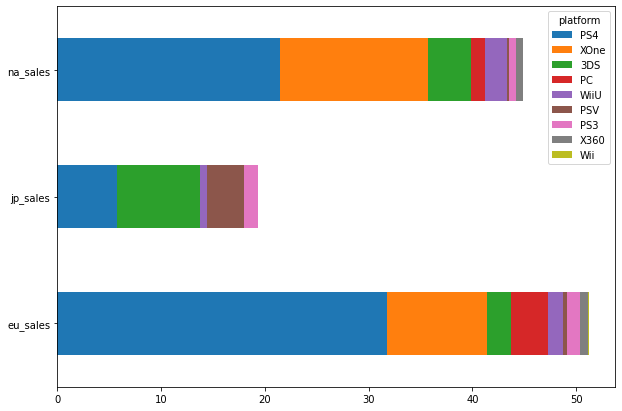

In [ ]:
plot_df = sales_2016_regions[['eu_sales', 'jp_sales','na_sales']].T
plot_df.plot.barh(stacked=True, figsize=(10,7))

### Top 5 genres - 2016 sales per region
- North America: Shooter is the top (36%) followed by Action (20%)
- Japan: Action: 36%, followed closely by Role-Playing 34%
- Europe: Shooter 31% followed by Sports 34%

In [ ]:
sales_2016_regions = games[games['year_of_release'] == 2016].pivot_table(index='genre', values
    =['na_sales', 'eu_sales', 'jp_sales', 'total_sales'],aggfunc='sum').sort_values(
        by='total_sales', ascending=False)
sales_2016_regions['eu_sales(%)'] = sales_2016_regions['eu_sales'] / sales_2016_regions['eu_sales'].sum() * 100
sales_2016_regions['jp_sales(%)'] = sales_2016_regions['jp_sales'] / sales_2016_regions['jp_sales'].sum() * 100
sales_2016_regions['na_sales(%)'] = sales_2016_regions['na_sales'] / sales_2016_regions['na_sales'].sum() * 100
sales_2016_regions.head(5)

,eu_sales,jp_sales,na_sales,total_sales,eu_sales(%),jp_sales(%),na_sales(%)
genre,,,,,,,
Shooter,15.90,1.06,16.24,38.22,31.04,5.49,36.15
Action,10.68,7.07,9.29,30.11,20.85,36.61,20.68
Sports,12.01,0.92,7.54,23.49,23.45,4.76,16.78
Role-Playing,4.28,6.61,5.89,18.18,8.36,34.23,13.11
Fighting,1.34,0.75,1.84,4.47,2.62,3.88,4.10


### ESRB Rating impact on 2016 sales per region
- We can notice that M (Mature 17+) is leading in NA and Europe
- T (Teen) is the leader in Japan

In [ ]:
sales_2016_regions = games[games['year_of_release'] == 2016].pivot_table(index='rating', values
    =['na_sales', 'eu_sales', 'jp_sales', 'total_sales'],aggfunc='sum').sort_values(
        by='total_sales', ascending=False)
sales_2016_regions['eu_sales(%)'] = sales_2016_regions['eu_sales'] / sales_2016_regions['eu_sales'].sum() * 100
sales_2016_regions['jp_sales(%)'] = sales_2016_regions['jp_sales'] / sales_2016_regions['jp_sales'].sum() * 100
sales_2016_regions['na_sales(%)'] = sales_2016_regions['na_sales'] / sales_2016_regions['na_sales'].sum() * 100
sales_2016_regions

,eu_sales,jp_sales,na_sales,total_sales,eu_sales(%),jp_sales(%),na_sales(%)
rating,,,,,,,
M,18.18,1.30,17.11,42.02,39.82,24.07,44.92
E,13.67,1.10,7.97,25.84,29.95,20.37,20.92
T,9.99,2.55,9.20,24.91,21.88,47.22,24.15
E10+,3.81,0.45,3.81,9.13,8.35,8.33,10.00


### Step 5. Test the following hypotheses:

- Average user ratings of the Xbox One (XOne) and PC platforms are the same.
- Average user ratings for the Action and Sports genres are different.

Set the alpha threshold value yourself.
<br>Explain:
- How you formulated the null and alternative hypotheses
- What criteria you used to test the hypotheses, and why

#### Testing hypothesis that average user ratings of the Xbox One (XOne) and PC platforms is the same
The formulation we use:
- H0: Average user ratings of the Xbox One (XOne) and PC platforms is the same.
- H1: Average user ratings of the Xbox One (XOne) and PC platforms is NOT the same.

Note: PC games were released from 1980, while XOne games only from 2013. For this reason we issued the condition of games from 2013 and on.
<br>The criteria we will use is T-Test with Alpha value of 0.05 which is the common practice.

In [ ]:
from scipy import stats as st
user_rating_xone = games[games['year_of_release'] >= 2013].query('platform == "XOne"')['user_score'].copy()
user_rating_pc = games[games['year_of_release'] >= 2013].query('platform == "PC"')['user_score'].copy()
user_rating_xone.dropna(inplace=True)
user_rating_pc.dropna(inplace=True)

alpha = .05 # critical statistical significance
results = st.ttest_ind(
        user_rating_xone, 
        user_rating_pc, equal_var=False)
print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("H0 rejected: Average user ratings of the Xbox One (XOne) and PC platforms is NOT the same")
else:
        print("H0 cannot be rejected: Average user ratings of the Xbox One (XOne) and PC platforms is the same")

p-value:  0.16174359801784308
H0 cannot be rejected: Average user ratings of the Xbox One (XOne) and PC platforms is the same


<div style="border:solid #ebd731 4px; padding: 20px">Please import all the modules in a notebook at the top, in your cell with other imports.</div>

#### Testing hypothesis that average user ratings for Action and Sports genres are different
The formulation we use:
- H0: Average user ratings of Action and Sports genres is the same.
- H1: Average user ratings of Action and Sports genres is NOT the same.

The criteria we will use is T-Test with Alpha value of 0.05 which is the common practice.

In [ ]:
user_rating_action = games[games['year_of_release'] >= 2010].query('genre == "Action"')['user_score'].copy()
user_rating_sports = games[games['year_of_release'] >= 2010].query('genre == "Sports"')['user_score'].copy()
user_rating_action.dropna(inplace=True)
user_rating_sports.dropna(inplace=True)

alpha = .05 # critical statistical significance
results = st.ttest_ind(
        user_rating_action, 
        user_rating_sports, equal_var=False)
print('p-value: ', results.pvalue)
if (results.pvalue < alpha):
        print("H0 rejected: Average user ratings of Action and Sports genres is NOT the same")
else:
        print("H0 cannot be rejected: Average user ratings of Action and Sports genres is the same")

p-value:  5.704356296291296e-16
H0 rejected: Average user ratings of Action and Sports genres is NOT the same


<div style="border:solid green 4px; padding: 20px">Hypotheses are correctly stated and tested.</div>

### Step 6. Write a general conclusion

1. The data contains information on games released between 1980 to 2016 (a period of 36 years).
2. During this long period, new platforms were released, and old platforms were kicked out. Average lifespan of platform: 11.8 years.
3. The users and critics scores have only small impact on the sales – mainly is hit games (sales above 1M USD) receiving scores in top quartile.
4. Main drive for sale is the platform (there is high variation in sales between platforms). In 2016 PS4 is the top selling platform, followed by XOne and 3DS.
5. Another major sales drive is the genre of the game: in 2016 popular games were Shooter, Action, Sports and Role Playing.
6. Platforms differences between the regions (2016):
  - North America: PS4 almost 50% of the market followed by XOne (31%)
  - Japan: 3DS: 41% - in fact this platform is popular mostly in Japan. Following is PS4 with 30%
  - Europe: PS4 is dominating with 62%, followed by XOne 19%
7.	Genres differences between the regions (2016):
  - North America: Shooter is the top (36%) followed by Action (20%)
  - Japan: Action: 36%, followed closely by Role-Playing 34%
  - Europe: Shooter 31% followed by Sports 34%
8.	Different impact of ESBR rating between regions:
  - We can notice that M (Mature 17+) is leading in NA and Europe
  - T (Teen) is the leader in Japan

<div style="border:solid green 4px; padding: 20px">Great work overall! I have only small additions, as you see, but your work easily satisfy the criteria to be accepted. So, I thank you for your time and wish you to stay home and take care if possible!</div>